## Random Forest Regressor - Usando diferenças

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')
    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')
    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')
    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')
    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')


def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [3]:
grupo = 'Adesão - Grande - Filantropia' 

grupo_csv = "ade_g_filan.csv"

#path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

#Amostra do dataframe
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          32 non-null     int64  
 1   cd_ops       32 non-null     int64  
 2   trimestre    32 non-null     object 
 3   receita      32 non-null     float64
 4   despesa      32 non-null     float64
 5   benef        32 non-null     float64
 6   modalidade   32 non-null     object 
 7   port_ops     32 non-null     object 
 8   contratacao  32 non-null     object 
dtypes: float64(3), int64(2), object(4)
memory usage: 2.4+ KB


In [4]:
ind_econ = 'ind_econ.csv'

df_ind_econ = pd.read_csv(ind_econ, sep=';', decimal= ',', encoding='mbcs')

df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ['PNAD'] = df_ind_econ['PNAD'].astype('float') 

df_ind_econ['Dolar_diff'] = df_ind_econ['Dolar'].diff(1)

df_ind_econ['PNAD_diff'] = df_ind_econ['PNAD'].diff(1) 

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   trimestre   16 non-null     period[Q-DEC]
 1   IPCA        16 non-null     float64      
 2   Selic       16 non-null     float64      
 3   Dolar       16 non-null     float64      
 4   PNAD        16 non-null     float64      
 5   Dolar_diff  15 non-null     float64      
 6   PNAD_diff   15 non-null     float64      
dtypes: float64(6), period[Q-DEC](1)
memory usage: 1.0 KB


,trimestre,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [14]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                    'despesa':lambda x: sum_million(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('float')

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

#Tratamento dados benef

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

ans_agrup['benefm_diff'] = ans_agrup['benefm'].diff(1)
ans_agrup['benefm_diff_l1'] = ans_agrup['benefm_diff'].shift(1)
ans_agrup['benefm_diff_l2'] = ans_agrup['benefm_diff'].shift(2)

ans_agrup['benefm_diff2'] = ans_agrup['benefm_diff'].diff(1)
ans_agrup['benefm_diff2_l1'] = ans_agrup['benefm_diff2'].shift(1)
ans_agrup['benefm_diff2_l2'] = ans_agrup['benefm_diff2'].shift(2)


#Tratamento dados receita
ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)
ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['receita_diff'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff_l1'] = ans_agrup['receita_diff'].shift(1)
ans_agrup['receita_diff_l2'] = ans_agrup['receita_diff'].shift(2)

ans_agrup['receita_diff2'] = ans_agrup['receita_diff'].diff(1)
ans_agrup['receita_diff2_l1'] = ans_agrup['receita_diff2'].shift(1)
ans_agrup['receita_diff2_l2'] = ans_agrup['receita_diff2'].shift(2)


#Tratamento dados despesa

ans_agrup['despesa_l1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_l2'] = ans_agrup['despesa'].shift(2)

ans_agrup['despesa_diff'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff_l1'] = ans_agrup['despesa_diff'].shift(1)
ans_agrup['despesa_diff_l2'] = ans_agrup['despesa_diff'].shift(2)

ans_agrup['despesa_diff2'] = ans_agrup['despesa_diff'].diff(1)
ans_agrup['despesa_diff2_l1'] = ans_agrup['despesa_diff2'].shift(1)
ans_agrup['despesa_diff2_l2'] = ans_agrup['despesa_diff2'].shift(2)

#Variáveis Dummies

#ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup['dmy_covid'] = np.where((ans_agrup['trimestre'] >= '2020Q1') & (ans_agrup['trimestre'] <= '2020Q3'),0.0,1.0)

ans_agrup['dmy_n_ops'] = np.where((ans_agrup['trimestre'] == '2020Q1'),1.0,0.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   trimestre         16 non-null     period[Q-DEC]
 1   receita           16 non-null     float64      
 2   despesa           16 non-null     float64      
 3   benef             16 non-null     int32        
 4   n_ops             16 non-null     int32        
 5   pct_despesa       16 non-null     float64      
 6   ano               16 non-null     int32        
 7   n_tri             16 non-null     float64      
 8   n_tri_l1          15 non-null     float64      
 9   benefm            16 non-null     float64      
 10  benefm_diff       15 non-null     float64      
 11  benefm_diff_l1    14 non-null     float64      
 12  benefm_diff_l2    13 non-null     float64      
 13  benefm_diff2      14 non-null     float64      
 14  benefm_diff2_l1   13 non-null     float64   

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops
0,2018Q1,14.280000,10.230000,24320,2,71.640000,2018,1.000000,NaN,8106.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,2018Q2,14.880000,11.770000,23958,2,79.100000,2018,2.000000,1.000000,7986.000000,-120.666667,NaN,NaN,NaN,NaN,NaN,14.280000,NaN,0.600000,NaN,NaN,NaN,NaN,NaN,10.230000,NaN,1.540000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
2,2018Q3,15.680000,11.840000,23080,2,75.510000,2018,3.000000,2.000000,7693.333333,-292.666667,-120.666667,NaN,-172.000000,NaN,NaN,14.880000,14.280000,0.800000,0.600000,NaN,0.200000,NaN,NaN,11.770000,10.230000,0.070000,1.540000,NaN,-1.470000,NaN,NaN,1.000000,0.000000
3,2018Q4,15.960000,10.660000,22545,2,66.790000,2018,4.000000,3.000000,7515.000000,-178.333333,-292.666667,-120.666667,114.333333,-172.000000,NaN,15.680000,14.880000,0.280000,0.800000,0.600000,-0.520000,0.200000,NaN,11.840000,11.770000,-1.180000,0.070000,1.540000,-1.250000,-1.470000,NaN,1.000000,0.000000
4,2019Q1,15.560000,10.750000,21998,2,69.090000,2019,1.000000,4.000000,7332.666667,-182.333333,-178.333333,-292.666667,-4.000000,114.333333,-172.000000,15.960000,15.680000,-0.400000,0.280000,0.800000,-0.680000,-0.520000,0.200000,10.660000,11.840000,0.090000,-1.180000,0.070000,1.270000,-1.250000,-1.470000,1.000000,0.000000
5,2019Q2,15.250000,11.960000,21510,2,78.430000,2019,2.000000,1.000000,7170.000000,-162.666667,-182.333333,-178.333333,19.666667,-4.000000,114.333333,15.560000,15.960000,-0.310000,-0.400000,0.280000,0.090000,-0.680000,-0.520000,10.750000,10.660000,1.210000,0.090000,-1.180000,1.120000,1.270000,-1.250000,1.000000,0.000000
6,2019Q3,15.810000,11.370000,20940,2,71.920000,2019,3.000000,2.000000,6980.000000,-190.000000,-162.666667,-182.333333,-27.333333,19.666667,-4.000000,15.250000,15.560000,0.560000,-0.310000,-0.400000,0.870000,0.090000,-0.680000,11.960000,10.750000,-0.590000,1.210000,0.090000,-1.800000,1.120000,1.270000,1.000000,0.000000
7,2019Q4,15.530000,13.370000,20368,2,86.090000,2019,4.000000,3.000000,6789.333333,-190.666667,-190.000000,-162.666667,-0.666667,-27.333333,19.666667,15.810000,15.250000,-0.280000,0.560000,-0.310000,-0.840000,0.870000,0.090000,11.370000,11.960000,2.000000,-0.590000,1.210000,2.590000,-1.800000,1.120000,1.000000,0.000000
8,2020Q1,14.890000,10.160000,19529,2,68.230000,2020,1.000000,4.000000,6509.666667,-279.666667,-190.666667,-190.000000,-89.000000,-0.666667,-27.333333,15.530000,15.810000,-0.640000,-0.280000,0.560000,-0.360000,-0.840000,0.870000,13.370000,11.370000,-3.210000,2.000000,-0.590000,-5.210000,2.590000,-1.800000,0.000000,1.000000
9,2020Q2,15.100000,7.990000,18780,2,52.910000,2020,2.000000,1.000000,6260.000000,-249.666667,-279.666667,-190.666667,30.000000,-89.000000,-0.666667,14.890000,15.530000,0.210000,-0.640000,-0.280000,0.850000,-0.360000,-0.840000,10.160000,13.370000,-2.170000,-3.210000,2.000000,1.040000,-5.210000,2.590000,0.000000,0.000000


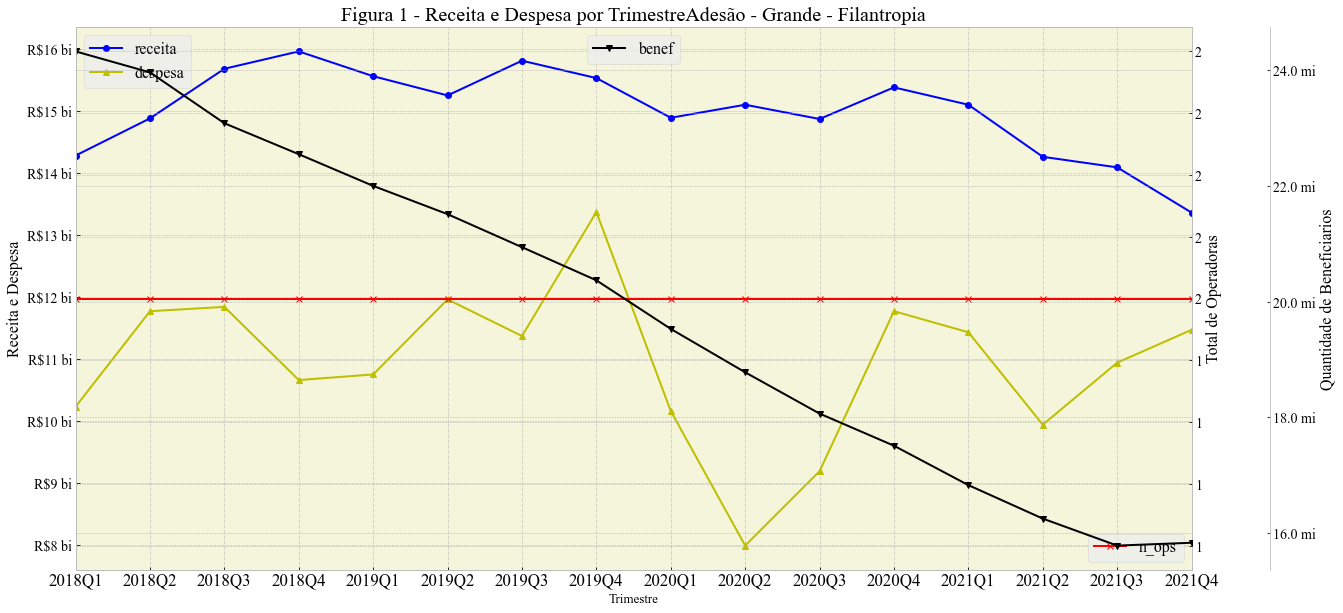

In [15]:
df_plot = ans_agrup.copy()

df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [9]:
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,14.280000,10.230000,24320,2,71.640000,2018,1.000000,NaN,8106.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,14.880000,11.770000,23958,2,79.100000,2018,2.000000,1.000000,7986.000000,-120.666667,NaN,NaN,NaN,NaN,NaN,14.280000,NaN,0.600000,NaN,NaN,NaN,NaN,NaN,10.230000,NaN,1.540000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,15.680000,11.840000,23080,2,75.510000,2018,3.000000,2.000000,7693.333333,-292.666667,-120.666667,NaN,-172.000000,NaN,NaN,14.880000,14.280000,0.800000,0.600000,NaN,0.200000,NaN,NaN,11.770000,10.230000,0.070000,1.540000,NaN,-1.470000,NaN,NaN,1.000000,0.000000,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,15.960000,10.660000,22545,2,66.790000,2018,4.000000,3.000000,7515.000000,-178.333333,-292.666667,-120.666667,114.333333,-172.000000,NaN,15.680000,14.880000,0.280000,0.800000,0.600000,-0.520000,0.200000,NaN,11.840000,11.770000,-1.180000,0.070000,1.540000,-1.250000,-1.470000,NaN,1.000000,0.000000,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,15.560000,10.750000,21998,2,69.090000,2019,1.000000,4.000000,7332.666667,-182.333333,-178.333333,-292.666667,-4.000000,114.333333,-172.000000,15.960000,15.680000,-0.400000,0.280000,0.800000,-0.680000,-0.520000,0.200000,10.660000,11.840000,0.090000,-1.180000,0.070000,1.270000,-1.250000,-1.470000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,15.250000,11.960000,21510,2,78.430000,2019,2.000000,1.000000,7170.000000,-162.666667,-182.333333,-178.333333,19.666667,-4.000000,114.333333,15.560000,15.960000,-0.310000,-0.400000,0.280000,0.090000,-0.680000,-0.520000,10.750000,10.660000,1.210000,0.090000,-1.180000,1.120000,1.270000,-1.250000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,15.810000,11.370000,20940,2,71.920000,2019,3.000000,2.000000,6980.000000,-190.000000,-162.666667,-182.333333,-27.333333,19.666667,-4.000000,15.250000,15.560000,0.560000,-0.310000,-0.400000,0.870000,0.090000,-0.680000,11.960000,10.750000,-0.590000,1.210000,0.090000,-1.800000,1.120000,1.270000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,15.530000,13.370000,20368,2,86.090000,2019,4.000000,3.000000,6789.333333,-190.666667,-190.000000,-162.666667,-0.666667,-27.333333,19.666667,15.810000,15.250000,-0.280000,0.560000,-0.310000,-0.840000,0.870000,0.090000,11.370000,11.960000,2.000000,-0.590000,1.210000,2.590000,-1.800000,1.120000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,14.890000,10.160000,19529,2,68.230000,2020,1.000000,4.000000,6509.666667,-279.666667,-190.666667,-190.000000,-89.000000,-0.666667,-27.333333,15.530000,15.810000,-0.640000,-0.280000,0.560000,-0.360000,-0.840000,0.870000,13.370000,11.370000,-3.210000,2.000000,-0.590000,-5.210000,2.590000,-1.800000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,15.100000,7.990000,18780,2,52.910000,2020,2.000000,1.000000,6260.000000,-249.666667,-279.666667,-190.666667,30.000000,-89.000000,-0.666667,14.890000,15.530000,0.210000,-0.640000,-0.280000,0.850000,-0.360000,-0.840000,10.160000,13.370000,-2.170000,-3.210000,2.000000,1.040000,-5.210000,2.590000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [10]:
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

In [11]:
ans_agrup_full['benefm'].iloc[-1]

5279.0

In [12]:
ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2019Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receita           12 non-null     float64
 1   despesa           12 non-null     float64
 2   benef             12 non-null     int32  
 3   n_ops             12 non-null     int32  
 4   pct_despesa       12 non-null     float64
 5   ano               12 non-null     int32  
 6   n_tri             12 non-null     float64
 7   n_tri_l1          12 non-null     float64
 8   benefm            12 non-null     float64
 9   benefm_diff       12 non-null     float64
 10  benefm_diff_l1    12 non-null     float64
 11  benefm_diff_l2    12 non-null     float64
 12  benefm_diff2      12 non-null     float64
 13  benefm_diff2_l1   12 non-null     float64
 14  benefm_diff2_l2   12 non-null     float64
 15  receita_l1        12 non-null     float64
 16  receita_l2        12 non

In [89]:
columns_receita = ['receita', 'receita_diff', 'despesa', 'despesa_diff', 'benefm', 'benefm_diff']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,2.830000,2.150000,1917215,39,75.970000,2020,3.000000,2.000000,639071.666667,8234.000000,5367.666667,39636.333333,2866.333333,-34268.666667,31645.666667,2.790000,2.750000,0.040000,0.040000,0.100000,0.000000,-0.060000,0.000000,1.750000,2.100000,0.400000,-0.350000,0.020000,0.750000,-0.370000,-0.110000,0.000000,0.000000,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000
2020Q4,2.980000,2.460000,1944236,39,82.550000,2020,4.000000,3.000000,648078.666667,9007.000000,8234.000000,5367.666667,773.000000,2866.333333,-34268.666667,2.830000,2.790000,0.150000,0.040000,0.040000,0.110000,0.000000,-0.060000,2.150000,1.750000,0.310000,0.400000,-0.350000,-0.090000,0.750000,-0.370000,1.000000,0.000000,0.031314,0.000047,5.458467,3841.000000,0.150934,4.000000
2021Q1,3.100000,2.410000,1937524,39,77.740000,2021,1.000000,4.000000,645841.333333,-2237.333333,9007.000000,8234.000000,-11244.333333,773.000000,2866.333333,2.980000,2.830000,0.120000,0.150000,0.040000,-0.030000,0.110000,0.000000,2.460000,2.150000,-0.050000,0.310000,0.400000,-0.360000,-0.090000,0.750000,1.000000,0.000000,0.020525,0.000048,5.249900,3760.000000,-0.208567,-81.000000


receita


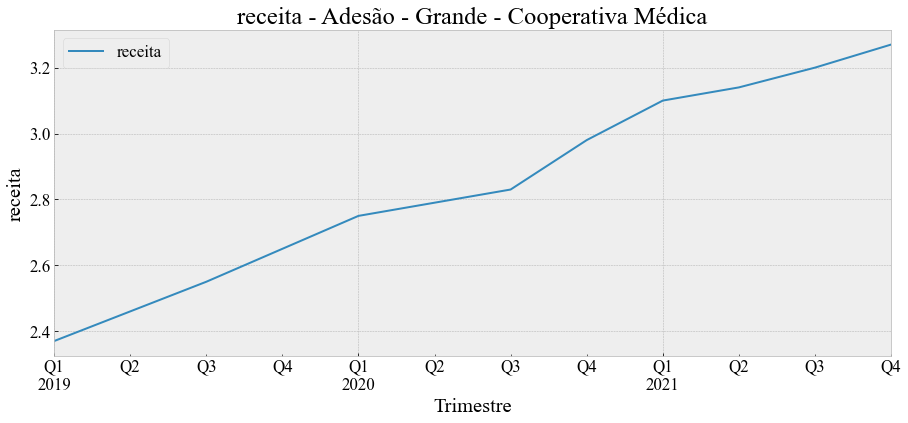

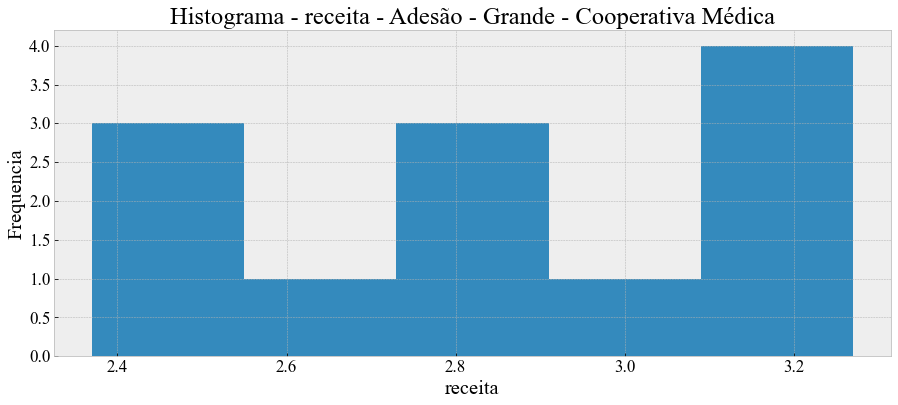

receita_diff


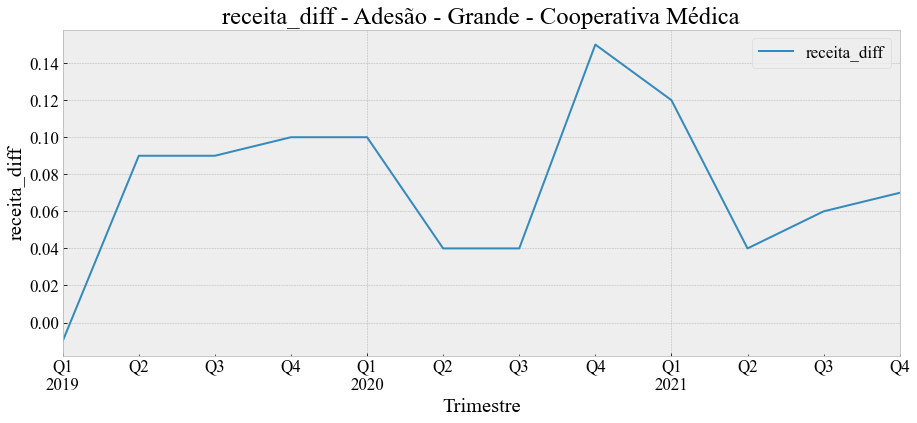

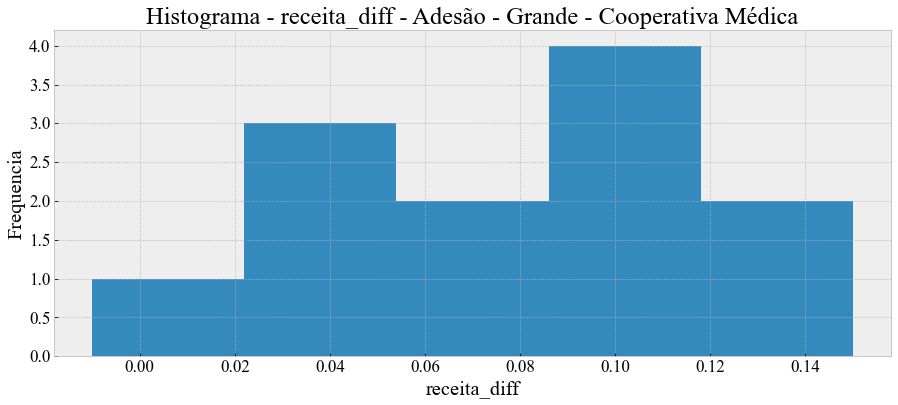

despesa


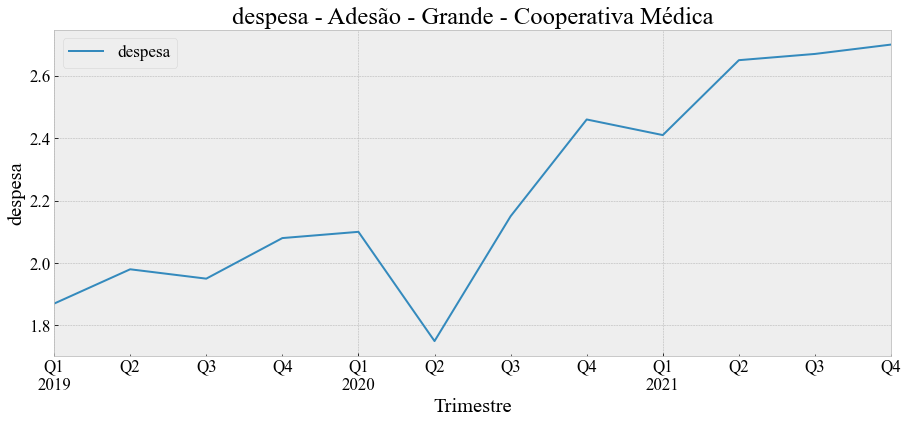

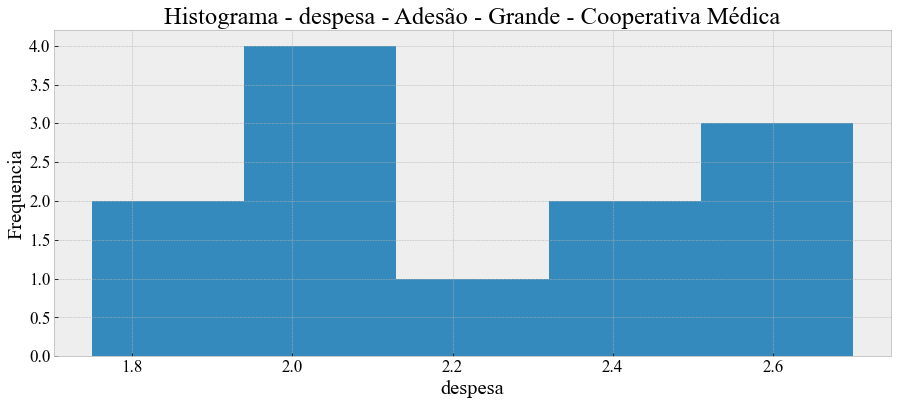

despesa_diff


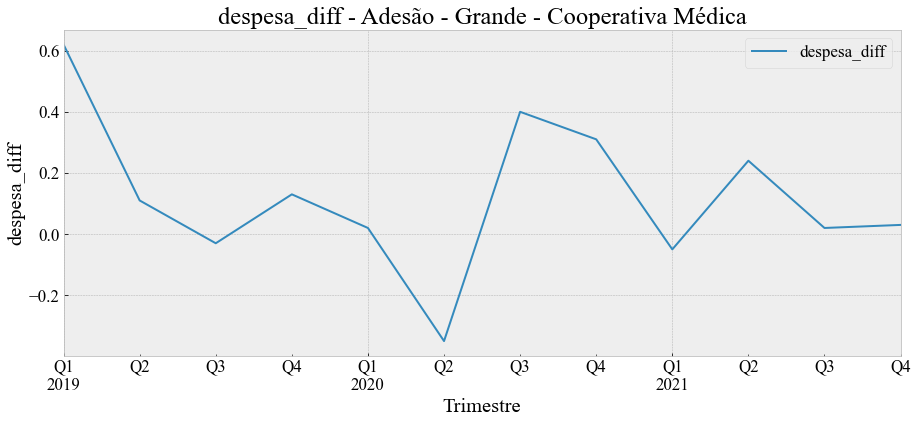

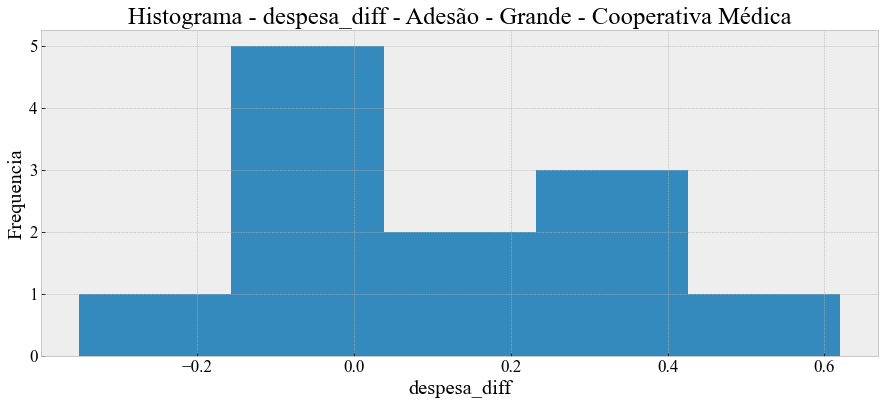

benefm


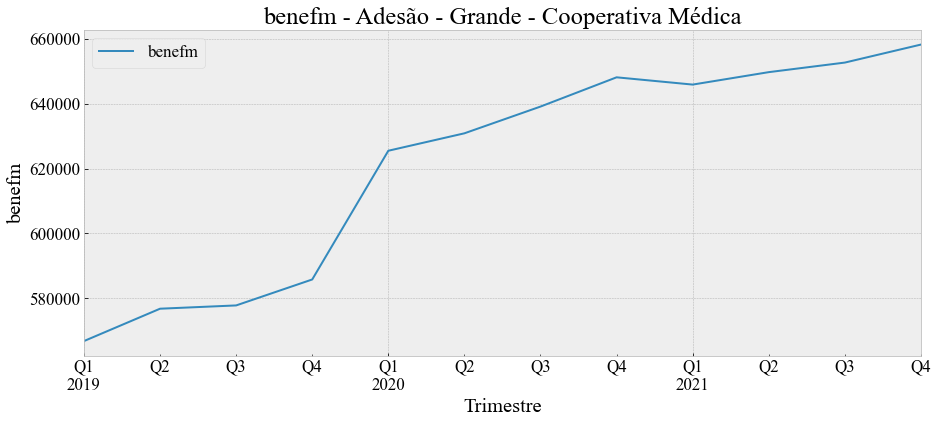

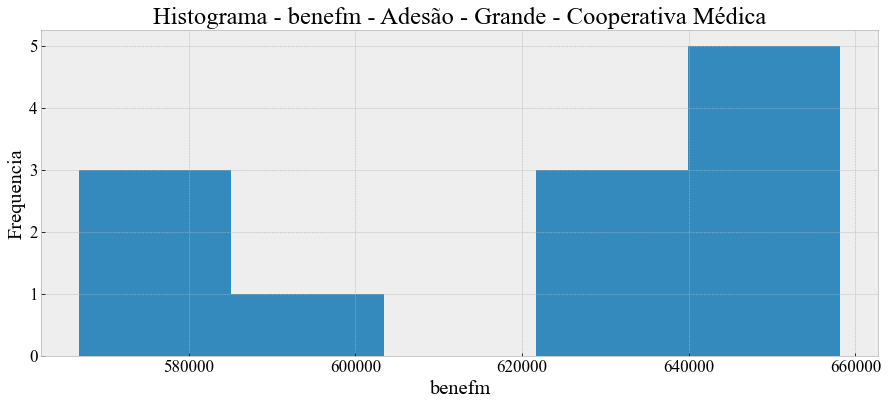

benefm_diff


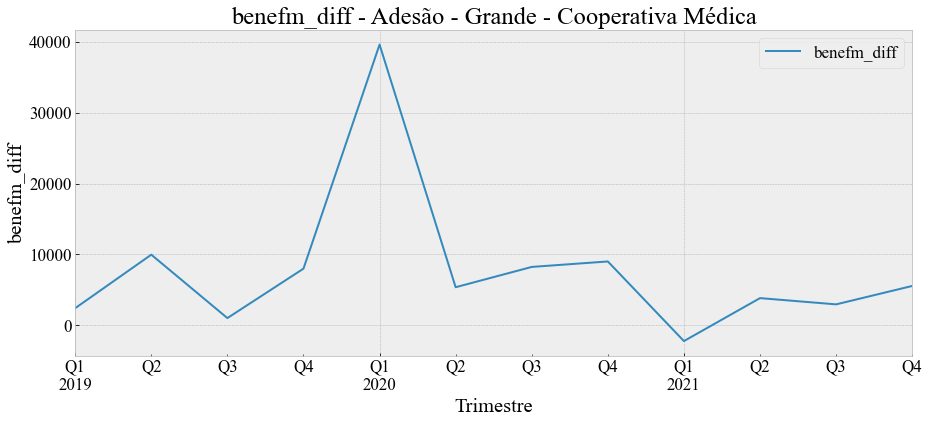

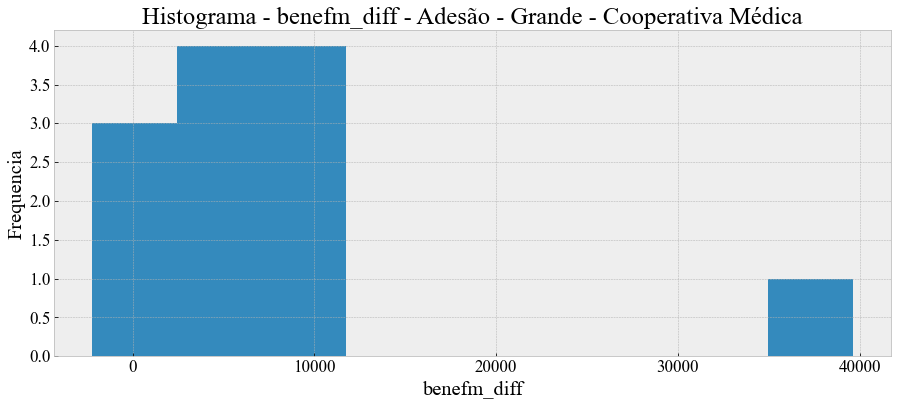

In [90]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

## 1 Etapa -  Forecast da benef - Random Forest

In [91]:
#ans_agrup_benefm = ans_agrup_full[['n_tri','n_tri_l1','benefm','benefm_diff','benefm_diff_l1','benefm_diff_l2','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid']]

ans_agrup_benefm = ans_agrup_full[['n_tri','n_tri_l1','benefm','benefm_diff','benefm_diff2','benefm_diff_l1','benefm_diff2_l1','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_benefm = ans_agrup_benefm.dropna()

display(ans_agrup_benefm.info())

ans_agrup_benefm

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 13 entries, 2018Q4 to 2021Q4
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   n_tri            13 non-null     float64
 1   n_tri_l1         13 non-null     float64
 2   benefm           13 non-null     float64
 3   benefm_diff      13 non-null     float64
 4   benefm_diff2     13 non-null     float64
 5   benefm_diff_l1   13 non-null     float64
 6   benefm_diff2_l1  13 non-null     float64
 7   IPCA             13 non-null     float64
 8   Selic            13 non-null     float64
 9   Dolar            13 non-null     float64
 10  Dolar_diff       13 non-null     float64
 11  PNAD             13 non-null     float64
 12  PNAD_diff        13 non-null     float64
 13  dmy_covid        13 non-null     float64
 14  dmy_n_ops        13 non-null     float64
dtypes: float64(15)
memory usage: 1.6 KB


None

,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff2,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,564459.666667,4895.666667,1121.333333,3774.333333,-260.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,566867.333333,2407.666667,-2488.000000,4895.666667,1121.333333,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,576833.333333,9966.000000,7558.333333,2407.666667,-2488.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,577843.000000,1009.666667,-8956.333333,9966.000000,7558.333333,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,585833.666667,7990.666667,6981.000000,1009.666667,-8956.333333,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,625470.000000,39636.333333,31645.666667,7990.666667,6981.000000,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,630837.666667,5367.666667,-34268.666667,39636.333333,31645.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,639071.666667,8234.000000,2866.333333,5367.666667,-34268.666667,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,648078.666667,9007.000000,773.000000,8234.000000,2866.333333,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [92]:
#Create X and y object
#X_benefm = ans_agrup_benefm[['n_tri','n_tri_l1','benefm_diff_l1','benefm_diff_l2','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid']]

X_benefm = ans_agrup_benefm[['n_tri','n_tri_l1','benefm_diff_l1','benefm_diff2_l1','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_benefm = ans_agrup_benefm['benefm_diff']

#Verificação da estacionariedade do número beneficiarios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_benefm, 'benefm_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column benefm_diff
Test Statistic                 -3.233001
p-value                         0.018152
No Lags Used                    0.000000
Number of Observartions Used   12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


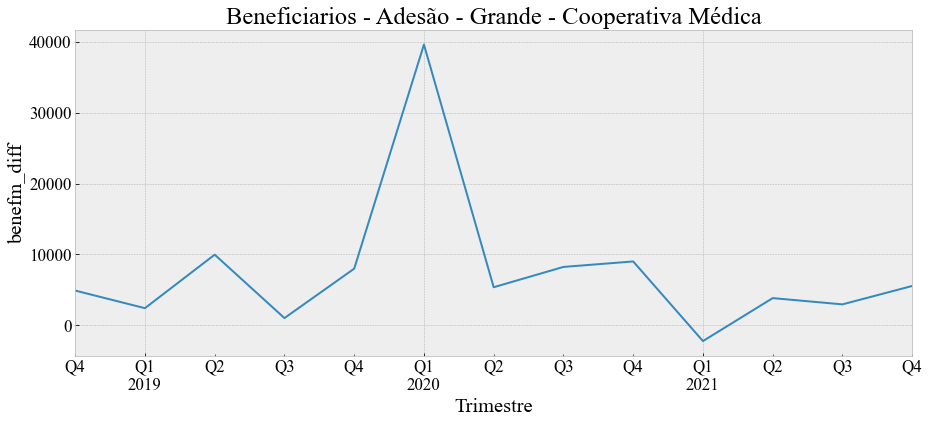

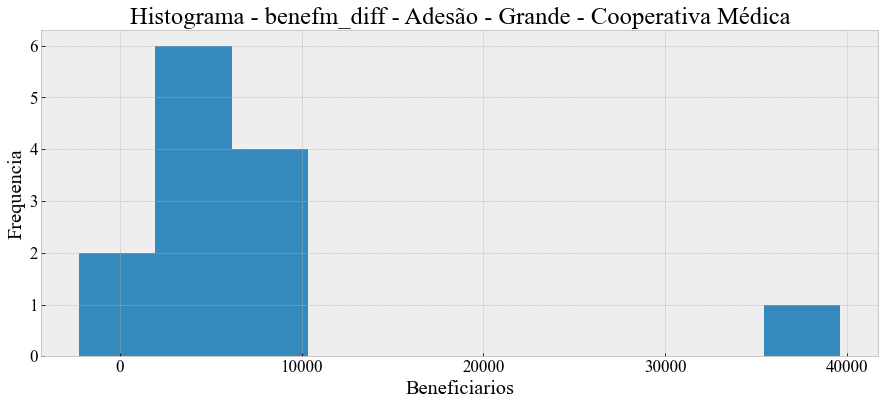

In [93]:
y_benefm.plot(y = 'Beneficiarios', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Beneficiarios - '+ grupo)
plt.show()

y_benefm.hist(bins='auto',figsize=(15,6))
plt.xlabel('Beneficiarios')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [94]:
# Create Train test split
X_benefm_train, X_benefm_test, y_benefm_train, y_benefm_test = train_test_split(X_benefm,y_benefm, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm_train)
X_benefm_train_scaled = scaler_X_benefm_train.transform(X_benefm_train)

y_benef_train_reshaped = y_benefm_train.to_numpy().reshape(-1,1)

scaler_y_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm_train.fit(y_benef_train_reshaped)
y_benefm_train_scaled = scaler_y_benefm_train.transform(y_benef_train_reshaped)

In [95]:
#Inicio do treino

rf_regr_benefm = GridSearchCV( RandomForestRegressor(oob_score=True),
                      {'max_features':[0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                      'n_estimators':[5,10,15,20,30,40,50,100,500],
                      'max_depth': [2,3,4,5,6,7,8,9,10]},
                       scoring='r2', n_jobs=-1, verbose=True)

#Bayesian 

rf_regr_benefm.fit(X_benefm_train_scaled,y_benefm_train_scaled)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
                                          0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100, 500]},
             scoring='r2', verbose=True)

In [96]:
X_benefm_test_scaled = scaler_X_benefm_train.transform(X_benefm_test)

y_benefm_pred_scaled = rf_regr_benefm.predict(X_benefm_test_scaled)
y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
y_benefm_pred = y_benefm_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_benefm_test),list(y_benefm_pred))
print('')
print('Hyper parameters')
print(rf_regr_benefm.best_params_)

Mean_Squared_Error_(MSE) is : 35283229.20277814
Root_Mean_Squared_Error_(RMSE) is : 5939.968788030636
Mean_Absolute_Error_(MAE) is : 5164.516666666666
Mean_Absolute_Percentage_Error (MAPE) is : 1.5753350295766144
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.7462291733091034
Coefficient of determination R^2 is : -19.899079873418152


Hyper parameters
{'max_depth': 6, 'max_features': 0.65, 'n_estimators': 10}


In [97]:
fi = pd.DataFrame( {'features': X_benefm_train.columns,
                    'importance': rf_regr_benefm.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
9,dmy_n_ops,0.338014
3,benefm_diff2_l1,0.225471
2,benefm_diff_l1,0.167381
5,Selic,0.090242
0,n_tri,0.068885
4,IPCA,0.047230
8,dmy_covid,0.035459
6,Dolar_diff,0.019333
1,n_tri_l1,0.005371
7,PNAD_diff,0.002613


In [98]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'])
df_benefm_pred

,benefm
0,11045.633333
1,7775.400000


In [99]:
actual_df = pd.DataFrame(ans_agrup['benefm'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_benefm_pred)

res

,benefm
trimestre,
2019Q1,566867.333333
2019Q2,576833.333333
2019Q3,577843.000000
2019Q4,585833.666667
2020Q1,625470.000000
2020Q2,630837.666667
2020Q3,639071.666667
2020Q4,648078.666667
2021Q1,645841.333333


,benefm,benefm_1st_inv_diff
0,11045.633333,656886.966667
1,7775.400000,664662.366667


In [100]:
timeseries_evaluation_metrics_func(list(ans_agrup['benefm'].iloc[-2:]),list(res['benefm_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 30234344.77888929
Root_Mean_Squared_Error_(RMSE) is : 5498.576613896481
Mean_Absolute_Error_(MAE) is : 5384.333333333372
Mean_Absolute_Percentage_Error (MAPE) is : 0.008208409753442204
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.008173486639285151
Coefficient of determination R^2 is : -2.9328305849052203



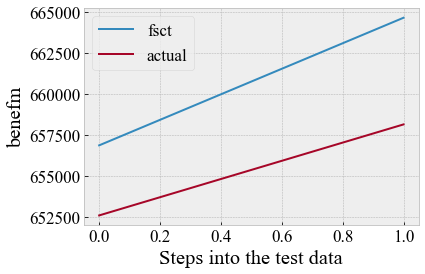

In [101]:
plt.plot(list(res['benefm_1st_inv_diff']))
plt.plot(list(ans_agrup['benefm'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('benefm')
plt.xlabel('Steps into the test data')
plt.show()

In [102]:
#dataframe teste para os 3 próximos anos

benefm_diff1_l1_list = [y_benefm.iloc[-1]]
benefm_diff1_l1_list_temp = [np.nan]*11
benefm_diff1_l1_list.extend(benefm_diff1_l1_list_temp)

benefm_diff2_l1_list = [ans_agrup_benefm['benefm_diff2'].iloc[-1]]
benefm_diff2_l1_list_temp = [np.nan]*11
benefm_diff2_l1_list.extend(benefm_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'benefm_diff_l1':  benefm_diff1_l1_list,
         'benefm_diff2_l1': benefm_diff2_l1_list,         
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list, 
         'dmy_covid': [1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_benef_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_benef_pred_test

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [103]:
#Treinar novamente o modelo com dados completos

In [104]:
y_pred_list = []

for i in range(len(df_benef_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_benefm_test = df_benef_pred_test.iloc[:i+1]
    X_benefm_test_scaled_pred = scaler_X_benefm_train.transform(X_benefm_test)

    y_benefm_pred_scaled = rf_regr_benefm.predict(X_benefm_test_scaled_pred)
    
    y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
    y_benefm_pred = y_benefm_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_benef_pred_test)-1:
        df_benef_pred_test['benefm_diff_l1'].iloc[i+1] = y_benefm_pred[-1]
        df_benef_pred_test['benefm_diff2_l1'].iloc[i+1] = y_benefm_pred[-1] - df_benef_pred_test['benefm_diff_l1'].iloc[i:i+1]

display(df_benef_pred_test)

y_benefm_pred

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,5259.500000,-285.833333,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,5182.200000,-77.300000,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,7907.100000,2724.900000,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,7948.800000,41.700000,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,2914.733333,-5034.066667,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,7634.133333,4719.400000,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,7460.366667,-173.766667,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,8091.000000,630.633333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,4848.366667,-3242.633333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([5259.5       , 5182.2       , 7907.1       , 7948.8       ,
       2914.73333333, 7634.13333333, 7460.36666667, 8091.        ,
       4848.36666667, 7258.03333333, 7871.5       , 7537.66666667])

In [105]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'], index = index_df_pred_test)
df_benefm_pred

,benefm
2022Q1,5259.500000
2022Q2,5182.200000
2022Q3,7907.100000
2022Q4,7948.800000
2023Q1,2914.733333
2023Q2,7634.133333
2023Q3,7460.366667
2023Q4,8091.000000
2024Q1,4848.366667
2024Q2,7258.033333


In [106]:
actual_df = pd.DataFrame(ans_agrup_benefm['benefm'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_benefm_pred)
pred_res.rename({'benefm_1st_inv_diff': 'benefm_pred'}, axis=1, inplace=True)
pred_res['benefm_pred']

2022Q1   663422.500000
2022Q2   668604.700000
2022Q3   676511.800000
2022Q4   684460.600000
2023Q1   687375.333333
2023Q2   695009.466667
2023Q3   702469.833333
2023Q4   710560.833333
2024Q1   715409.200000
2024Q2   722667.233333
2024Q3   730538.733333
2024Q4   738076.400000
Name: benefm_pred, dtype: float64

In [107]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['benefm'])
ans_agrup_benefm_join = ans_agrup_temp.append(pd.DataFrame(pred_res['benefm_pred']))
ans_agrup_benefm_join

,benefm,benefm_pred
2018Q1,551754.666667,NaN
2018Q2,555789.666667,NaN
2018Q3,559564.000000,NaN
2018Q4,564459.666667,NaN
2019Q1,566867.333333,NaN
2019Q2,576833.333333,NaN
2019Q3,577843.000000,NaN
2019Q4,585833.666667,NaN
2020Q1,625470.000000,NaN
2020Q2,630837.666667,NaN


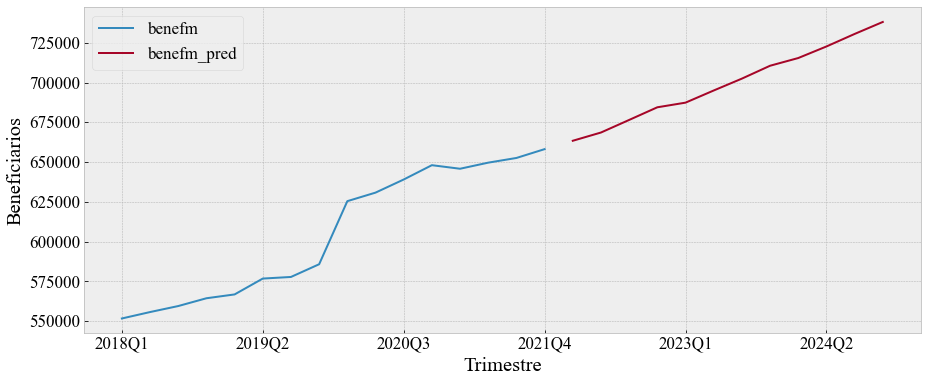

In [108]:
ans_agrup_benefm_join.plot(figsize=(15,6))
plt.legend(['benefm','benefm_pred'])
plt.ylabel('Beneficiarios')
plt.xlabel('Trimestre')
plt.show()

In [109]:
df_benefm_pred

,benefm
2022Q1,5259.500000
2022Q2,5182.200000
2022Q3,7907.100000
2022Q4,7948.800000
2023Q1,2914.733333
2023Q2,7634.133333
2023Q3,7460.366667
2023Q4,8091.000000
2024Q1,4848.366667
2024Q2,7258.033333


## Forecast da Receita - Random Forest

In [110]:
ans_agrup_rec = ans_agrup_full[['n_tri','n_tri_l1','receita','receita_diff','receita_diff2','receita_diff2_l1','receita_diff_l1','benefm_diff2_l1','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_rec = ans_agrup_rec.dropna()

ans_agrup_rec

,n_tri,n_tri_l1,receita,receita_diff,receita_diff2,receita_diff2_l1,receita_diff_l1,benefm_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,2.380000,0.090000,-0.040000,0.120000,0.130000,-260.666667,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,2.370000,-0.010000,-0.100000,-0.040000,0.090000,1121.333333,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,2.460000,0.090000,0.100000,-0.100000,-0.010000,-2488.000000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,2.550000,0.090000,0.000000,0.100000,0.090000,7558.333333,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.650000,0.100000,0.010000,0.000000,0.090000,-8956.333333,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.750000,0.100000,0.000000,0.010000,0.100000,6981.000000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,2.790000,0.040000,-0.060000,0.000000,0.100000,31645.666667,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.830000,0.040000,0.000000,-0.060000,0.040000,-34268.666667,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.980000,0.150000,0.110000,0.000000,0.040000,2866.333333,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [111]:
#Create X and y object
X_rec = ans_agrup_rec[['n_tri','n_tri_l1','receita_diff_l1','receita_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_rec = ans_agrup_rec['receita_diff']

#Verificação da estacionariedade da receita
print('#########################################################################')
print('Teste Estacionaridade')
print('#########################################################################')
Augmented_Dickey_Fuller_Test_func(y_rec, 'receita_diff')

#########################################################################
Teste Estacionaridade
#########################################################################
Results of Dickey-Fuller Test for column receita_diff
Test Statistic                 -5.206978
p-value                         0.000009
No Lags Used                    3.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


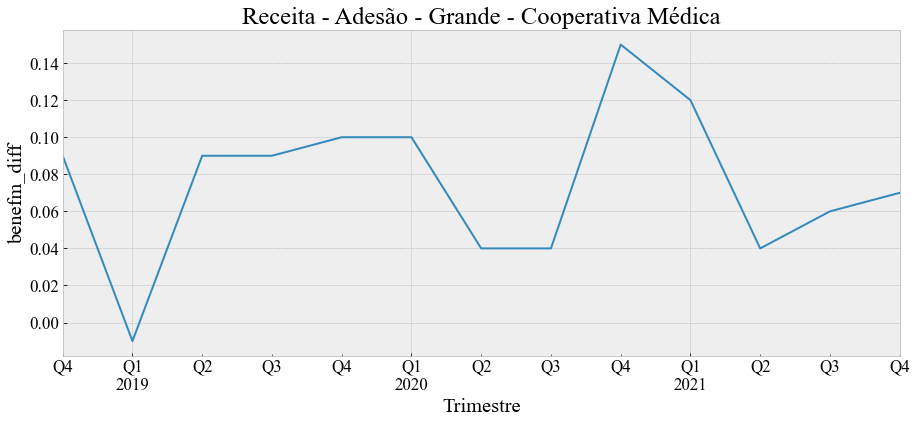

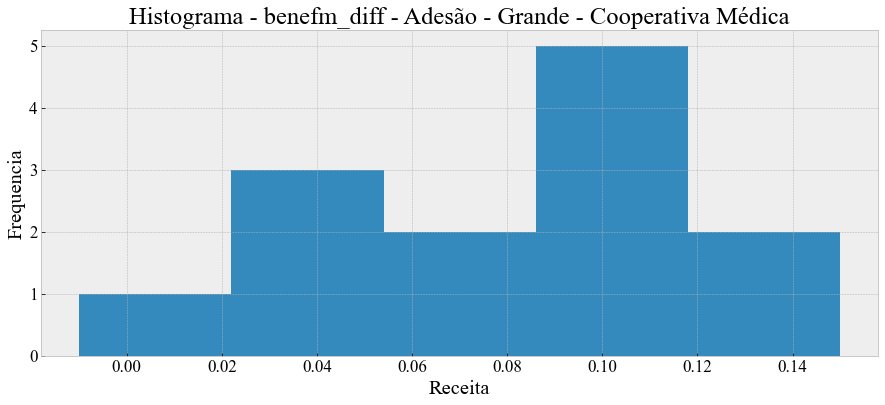

In [112]:
y_rec.plot(y = 'Receita', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y_rec.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [113]:
# Create Train test split
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec,y_rec, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec_train)
X_rec_train_scaled = scaler_X_rec_train.transform(X_rec_train)

y_rec_train_reshaped = y_rec_train.to_numpy().reshape(-1,1)

scaler_y_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec_train.fit(y_rec_train_reshaped)
y_rec_train_scaled = scaler_y_rec_train.transform(y_rec_train_reshaped)

In [114]:
rf_regr_rec = GridSearchCV( RandomForestRegressor(oob_score=True),
                            {'max_features':[0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                             'n_estimators':[5,10,15,20,30,40,50,100,500],
                             'max_depth': [2,3,4,5,6,7,8,9,10]},
                              scoring='r2', n_jobs=-1, verbose=True)

rf_regr_rec.fit(X_rec_train_scaled,y_rec_train_scaled)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
                                          0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100, 500]},
             scoring='r2', verbose=True)

In [115]:
X_rec_test_scaled = scaler_X_rec_train.transform(X_rec_test)

y_rec_pred = rf_regr_rec.predict(X_rec_test_scaled)
y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
y_rec_pred = y_rec_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_rec_test),list(y_rec_pred))
print(rf_regr_rec.best_params_)

Mean_Squared_Error_(MSE) is : 0.0010960000000000065
Root_Mean_Squared_Error_(RMSE) is : 0.033105890714493796
Mean_Absolute_Error_(MAE) is : 0.03000000000000007
Mean_Absolute_Percentage_Error (MAPE) is : 0.44761904761904914
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.356777493606139
Coefficient of determination R^2 is : -42.84000000000213

{'max_depth': 9, 'max_features': 0.5, 'n_estimators': 10}


In [116]:
fi = pd.DataFrame( {'features': X_rec_train.columns,
                    'importance': rf_regr_rec.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
5,IPCA,0.235762
3,receita_diff2_l1,0.174961
2,receita_diff_l1,0.151275
1,n_tri_l1,0.130100
6,Selic,0.078338
9,dmy_covid,0.062069
8,PNAD_diff,0.054488
0,n_tri,0.042649
4,benefm_diff,0.036271
7,Dolar_diff,0.034086


In [117]:
df_rec_pred = pd.DataFrame(y_rec_pred, columns=['receita'])
df_rec_pred

,receita
0,0.076000
1,0.114000


In [118]:
actual_df_rec = pd.DataFrame(ans_agrup['receita'].iloc[:-3])

display(actual_df_rec)

res_rec = inverse_diff(actual_df_rec,df_rec_pred)

res_rec

,receita
trimestre,
2019Q1,2.370000
2019Q2,2.460000
2019Q3,2.550000
2019Q4,2.650000
2020Q1,2.750000
2020Q2,2.790000
2020Q3,2.830000
2020Q4,2.980000
2021Q1,3.100000


,receita,receita_1st_inv_diff
0,0.076000,3.176000
1,0.114000,3.290000


In [119]:
timeseries_evaluation_metrics_func(list(ans_agrup['receita'].iloc[-2:]),list(res_rec['receita_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 0.00048800000000000086
Root_Mean_Squared_Error_(RMSE) is : 0.02209072203437454
Mean_Absolute_Error_(MAE) is : 0.02200000000000002
Mean_Absolute_Percentage_Error (MAPE) is : 0.006808103975535175
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.006812895920678158
Coefficient of determination R^2 is : 0.6016326530612219



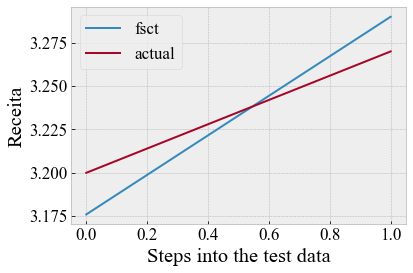

In [120]:
plt.plot(list(res_rec['receita_1st_inv_diff']))
plt.plot(list(ans_agrup['receita'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [121]:
#dataframe teste para os 3 próximos anos

receita_diff1_l1_list = [y_rec.iloc[-1]]
receita_diff1_l1_list_temp = [np.nan]*11
receita_diff1_l1_list.extend(receita_diff1_l1_list_temp)

receita_diff2_l1_list = [ans_agrup_rec['receita_diff2'].iloc[-1]]
receita_diff2_l1_list_temp = [np.nan]*11
receita_diff2_l1_list.extend(receita_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

#Lista de benefm diff estimados na etapa anterior desse código
benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'receita_diff_l1':  receita_diff1_l1_list,
         'receita_diff2_l1': receita_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_rec_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_rec_pred_test

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,5259.500000,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,5182.200000,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,7907.100000,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,7948.800000,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,2914.733333,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,7634.133333,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,7460.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,8091.000000,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,4848.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,7258.033333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [122]:
#y_pred_list = []

for i in range(len(df_rec_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_rec_test = df_rec_pred_test.iloc[:i+1]
    X_rec_test_scaled_test = scaler_X_rec_train.transform(X_rec_test)
    
    y_rec_pred = rf_regr_rec.predict(X_rec_test_scaled_test)
    y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
    y_rec_pred = y_rec_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_rec_pred_test)-1:
        df_rec_pred_test['receita_diff_l1'].iloc[i+1] = y_rec_pred[-1]
        df_rec_pred_test['receita_diff2_l1'].iloc[i+1] = y_rec_pred[-1] - df_rec_pred_test['receita_diff_l1'].iloc[i:i+1]

display(df_rec_pred_test)

y_rec_pred

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,5259.500000,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,0.116000,0.046000,5182.200000,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,0.095000,-0.021000,7907.100000,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,0.082000,-0.013000,7948.800000,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,0.116000,0.034000,2914.733333,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,0.104000,-0.012000,7634.133333,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,0.109000,0.005000,7460.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,0.098000,-0.011000,8091.000000,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,0.116000,0.018000,4848.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,0.105000,-0.011000,7258.033333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([0.116, 0.095, 0.082, 0.116, 0.104, 0.109, 0.098, 0.116, 0.105,
       0.098, 0.109, 0.116])

In [123]:
df_rec_pred = pd.DataFrame(y_rec_pred, columns=['receita'], index = index_df_pred_test)
df_rec_pred

,receita
2022Q1,0.116000
2022Q2,0.095000
2022Q3,0.082000
2022Q4,0.116000
2023Q1,0.104000
2023Q2,0.109000
2023Q3,0.098000
2023Q4,0.116000
2024Q1,0.105000
2024Q2,0.098000


In [124]:
actual_df_rec = pd.DataFrame(ans_agrup_rec['receita'])

pred_res_rec = inverse_diff(actual_df_rec,df_rec_pred)
pred_res_rec.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)
pred_res_rec['receita_pred']

2022Q1   3.386000
2022Q2   3.481000
2022Q3   3.563000
2022Q4   3.679000
2023Q1   3.783000
2023Q2   3.892000
2023Q3   3.990000
2023Q4   4.106000
2024Q1   4.211000
2024Q2   4.309000
2024Q3   4.418000
2024Q4   4.534000
Name: receita_pred, dtype: float64

In [125]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_rec_join = ans_agrup_temp.append(pd.DataFrame(pred_res_rec['receita_pred']))
ans_agrup_rec_join

,receita,receita_pred
2018Q1,2.150000,NaN
2018Q2,2.160000,NaN
2018Q3,2.290000,NaN
2018Q4,2.380000,NaN
2019Q1,2.370000,NaN
2019Q2,2.460000,NaN
2019Q3,2.550000,NaN
2019Q4,2.650000,NaN
2020Q1,2.750000,NaN
2020Q2,2.790000,NaN


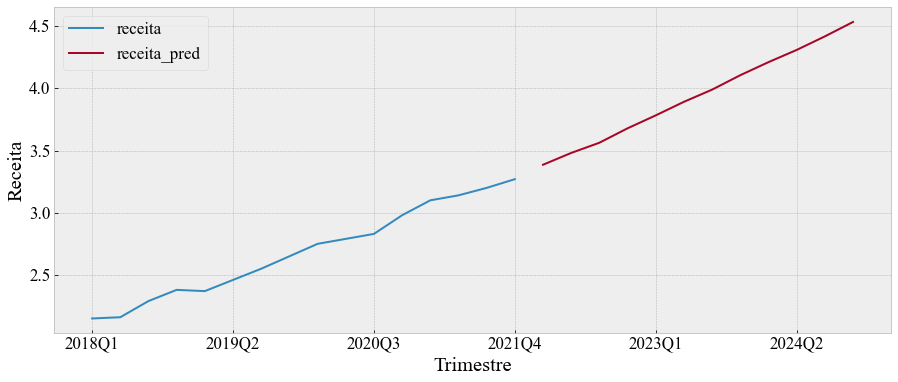

In [126]:
ans_agrup_rec_join.plot(figsize=(15,6))
plt.legend(['receita','receita_pred'])
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

## Forecast Despesa

In [127]:
ans_agrup_desp = ans_agrup_full[['n_tri','n_tri_l1','despesa','despesa_diff','despesa_diff2','despesa_diff2_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_desp = ans_agrup_desp.dropna()

ans_agrup_desp

,n_tri,n_tri_l1,despesa,despesa_diff,despesa_diff2,despesa_diff2_l1,despesa_diff_l1,despesa_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,1.250000,-0.600000,-0.810000,0.150000,0.210000,0.150000,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,1.870000,0.620000,1.220000,-0.810000,-0.600000,-0.810000,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,1.980000,0.110000,-0.510000,1.220000,0.620000,1.220000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,1.950000,-0.030000,-0.140000,-0.510000,0.110000,-0.510000,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.080000,0.130000,0.160000,-0.140000,-0.030000,-0.140000,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.100000,0.020000,-0.110000,0.160000,0.130000,0.160000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,1.750000,-0.350000,-0.370000,-0.110000,0.020000,-0.110000,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.150000,0.400000,0.750000,-0.370000,-0.350000,-0.370000,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.460000,0.310000,-0.090000,0.750000,0.400000,0.750000,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [128]:
#Create X and y object
X_desp = ans_agrup_desp[['n_tri','n_tri_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_desp = ans_agrup_desp['despesa_diff']

#Verificação da estacionariedade do número beneficiarios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_desp, 'despesa_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column despesa_diff
Test Statistic                 -2.139302
p-value                         0.229007
No Lags Used                    4.000000
Number of Observartions Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


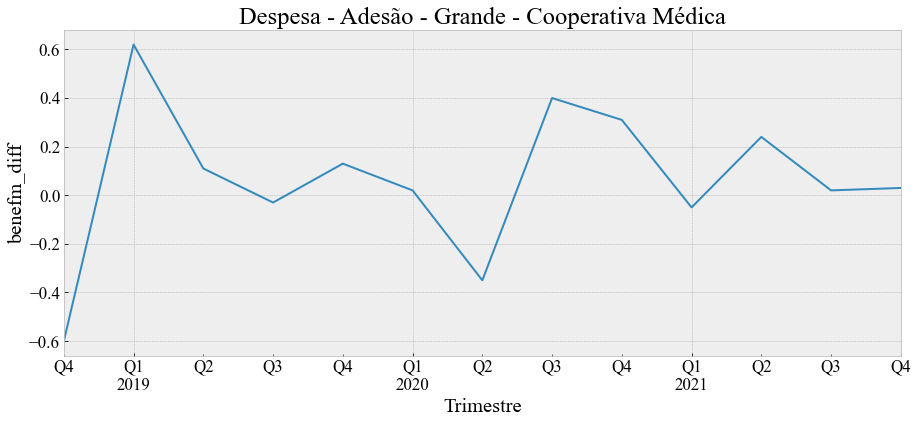

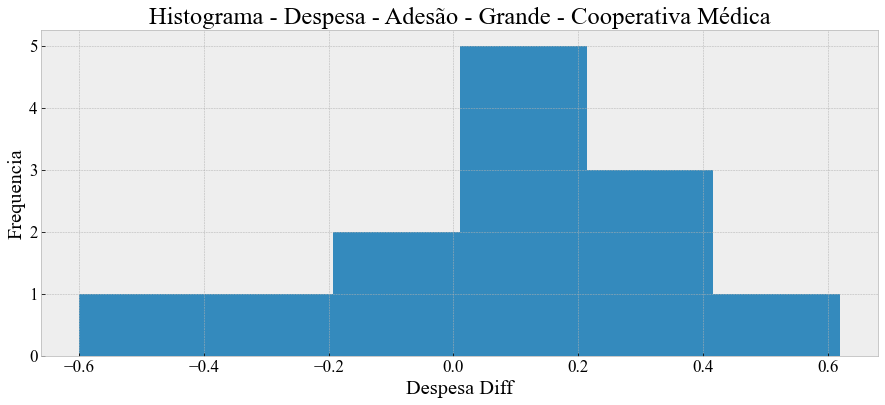

In [129]:
y_desp.plot(y = 'Despesa', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Despesa - '+ grupo)
plt.show()

y_desp.hist(bins='auto',figsize=(15,6))
plt.xlabel('Despesa Diff')
plt.ylabel('Frequencia')
plt.title(f'Histograma - '+'Despesa - ' + grupo)
plt.show()

In [130]:
# Create Train test split
X_desp_train, X_desp_test, y_desp_train, y_desp_test = train_test_split(X_desp,y_desp, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_desp_train.fit(X_desp_train)
X_desp_train_scaled = scaler_X_desp_train.transform(X_desp_train)

y_desp_train_reshaped = y_desp_train.to_numpy().reshape(-1,1)

scaler_y_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_desp_train.fit(y_desp_train_reshaped)
y_desp_train_scaled = scaler_y_desp_train.transform(y_desp_train_reshaped)

In [131]:
rf_regr_desp = GridSearchCV( RandomForestRegressor(oob_score=True),
                            {'max_features':[0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8],
                             'n_estimators':[5,10,15,20,30,40,50,100,500],
                             'max_depth': [2,3,4,5,6,7,8,9,10]},
                              scoring='r2', n_jobs=-1, verbose=True)


rf_regr_desp.fit(X_desp_train_scaled,y_desp_train_scaled)

#{'max_depth': 8, 'max_features': 0.4, 'n_estimators': 10}

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
                                          0.75, 0.8],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50, 100, 500]},
             scoring='r2', verbose=True)

In [132]:
X_desp_test_scaled = scaler_X_desp_train.transform(X_desp_test)

y_desp_pred = rf_regr_desp.predict(X_desp_test_scaled)
y_desp_pred = scaler_y_desp_train.inverse_transform(y_desp_pred.reshape(-1,1))
y_desp_pred = y_desp_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

timeseries_evaluation_metrics_func(list(y_desp_test),list(y_desp_pred))
print(rf_regr_desp.best_params_)

Mean_Squared_Error_(MSE) is : 0.01639999999999995
Root_Mean_Squared_Error_(RMSE) is : 0.12806248474865678
Mean_Absolute_Error_(MAE) is : 0.1279999999999998
Mean_Absolute_Percentage_Error (MAPE) is : 5.299999999999971
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 1.4435975609756073
Coefficient of determination R^2 is : -654.9999999999677

{'max_depth': 9, 'max_features': 0.55, 'n_estimators': 5}


In [133]:
fi = pd.DataFrame( {'features': X_desp_train.columns,
                    'importance': rf_regr_desp.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)    

,features,importance
6,IPCA,0.478718
4,despesa_diff2_l1,0.180637
9,PNAD_diff,0.120212
8,Dolar_diff,0.104301
1,n_tri_l1,0.038320
7,Selic,0.029623
5,benefm_diff,0.021053
3,despesa_diff2_l1,0.019703
2,despesa_diff_l1,0.006819
0,n_tri,0.000615


In [134]:
df_desp_pred = pd.DataFrame(y_desp_pred, columns=['despesa'])
df_desp_pred

,despesa
0,0.144000
1,0.162000


In [135]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'].iloc[:-2])

display(actual_desp_df)

res_desp = inverse_diff(actual_desp_df,df_desp_pred)

res_desp

,despesa
trimestre,
2018Q4,1.250000
2019Q1,1.870000
2019Q2,1.980000
2019Q3,1.950000
2019Q4,2.080000
2020Q1,2.100000
2020Q2,1.750000
2020Q3,2.150000
2020Q4,2.460000


,despesa,despesa_1st_inv_diff
0,0.144000,2.794000
1,0.162000,2.956000


In [136]:
timeseries_evaluation_metrics_func(list(ans_agrup['despesa'].iloc[-2:]),list(res_desp['despesa_1st_inv_diff']))

Mean_Squared_Error_(MSE) is : 0.0404559999999999
Root_Mean_Squared_Error_(RMSE) is : 0.20113676938839378
Mean_Absolute_Error_(MAE) is : 0.18999999999999972
Mean_Absolute_Percentage_Error (MAPE) is : 0.07062838119017883
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : 0.06795566609578747
Coefficient of determination R^2 is : -178.80444444444103



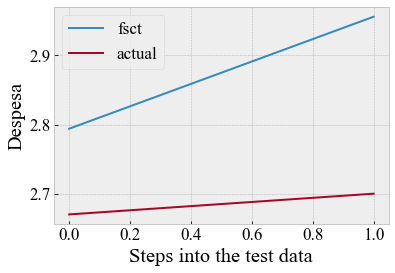

In [137]:
plt.plot(list(res_desp['despesa_1st_inv_diff']))
plt.plot(list(ans_agrup['despesa'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('Despesa')
plt.xlabel('Steps into the test data')
plt.show()

In [138]:
#dataframe teste para os 3 próximos anos

despesa_diff1_l1_list = [y_desp.iloc[-1]]
despesa_diff1_l1_list_temp = [np.nan]*11
despesa_diff1_l1_list.extend(despesa_diff1_l1_list_temp)

despesa_diff2_l1_list = [y_desp.iloc[-2]]
despesa_diff2_l1_list_temp = [np.nan]*11
despesa_diff2_l1_list.extend(despesa_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],
         'n_ops': [39.0]*12,
         'despesa_diff_l1':  despesa_diff1_l1_list,
         'despesa_diff_l2': despesa_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_desp_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_desp_pred_test

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,39.000000,0.030000,0.020000,5259.500000,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,39.000000,NaN,NaN,5182.200000,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,39.000000,NaN,NaN,7907.100000,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,39.000000,NaN,NaN,7948.800000,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,39.000000,NaN,NaN,2914.733333,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,39.000000,NaN,NaN,7634.133333,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,39.000000,NaN,NaN,7460.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,39.000000,NaN,NaN,8091.000000,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,39.000000,NaN,NaN,4848.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,39.000000,NaN,NaN,7258.033333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [139]:
for i in range(len(df_desp_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_desp_test = df_desp_pred_test.iloc[:i+1]
    X_desp_test_scaled_test = scaler_X_desp_train.transform(X_desp_test)

    y_desp_pred = rf_regr_desp.predict(X_desp_test_scaled_test)
    y_desp_pred = scaler_y_desp_train.inverse_transform(y_desp_pred.reshape(-1,1))
    y_desp_pred = y_desp_pred.reshape(-1)


    if i < len(df_desp_pred_test)-1:
        df_desp_pred_test['despesa_diff_l1'].iloc[i+1] = y_desp_pred[-1]
        df_desp_pred_test['despesa_diff_l2'].iloc[i+1] = y_rec_pred[-1] - df_desp_pred_test['despesa_diff_l1'].iloc[i:i+1]

display(df_desp_pred_test)

y_desp_pred

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,39.000000,0.030000,0.020000,5259.500000,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,39.000000,0.104000,0.086000,5182.200000,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,39.000000,0.144000,0.012000,7907.100000,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,39.000000,0.158000,-0.028000,7948.800000,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,39.000000,0.136000,-0.042000,2914.733333,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,39.000000,0.198000,-0.020000,7634.133333,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,39.000000,0.158000,-0.082000,7460.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,39.000000,0.118000,-0.042000,8091.000000,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,39.000000,0.136000,-0.002000,4848.366667,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,39.000000,0.100000,-0.020000,7258.033333,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([0.104, 0.144, 0.158, 0.136, 0.198, 0.158, 0.118, 0.136, 0.1  ,
       0.118, 0.136, 0.136])

In [140]:
df_desp_pred = pd.DataFrame(y_desp_pred, columns=['despesa'], index = index_df_pred_test)
df_desp_pred

,despesa
2022Q1,0.104000
2022Q2,0.144000
2022Q3,0.158000
2022Q4,0.136000
2023Q1,0.198000
2023Q2,0.158000
2023Q3,0.118000
2023Q4,0.136000
2024Q1,0.100000
2024Q2,0.118000


In [141]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'])
#actual_df.set_index('trimestre', inplace=True)
pred_res_desp = inverse_diff(actual_desp_df,df_desp_pred)
pred_res_desp.rename({'despesa_1st_inv_diff': 'despesa_pred'}, axis=1, inplace=True)
pred_res_desp['despesa_pred']

2022Q1   2.804000
2022Q2   2.948000
2022Q3   3.106000
2022Q4   3.242000
2023Q1   3.440000
2023Q2   3.598000
2023Q3   3.716000
2023Q4   3.852000
2024Q1   3.952000
2024Q2   4.070000
2024Q3   4.206000
2024Q4   4.342000
Name: despesa_pred, dtype: float64

In [142]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['despesa'])
ans_agrup_desp_join = ans_agrup_temp.append(pd.DataFrame(pred_res_desp['despesa_pred']))
ans_agrup_desp_join

,despesa,despesa_pred
2018Q1,1.580000,NaN
2018Q2,1.640000,NaN
2018Q3,1.850000,NaN
2018Q4,1.250000,NaN
2019Q1,1.870000,NaN
2019Q2,1.980000,NaN
2019Q3,1.950000,NaN
2019Q4,2.080000,NaN
2020Q1,2.100000,NaN
2020Q2,1.750000,NaN


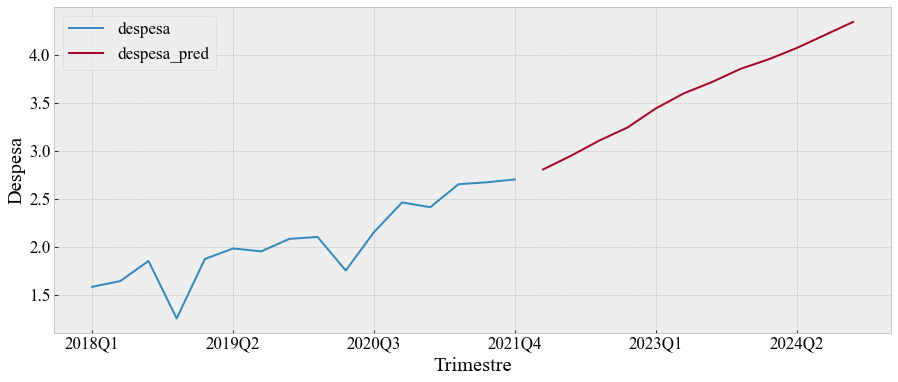

In [143]:
ans_agrup_desp_join.plot(figsize=(15,6))
plt.legend(['despesa','despesa_pred'])
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()

In [144]:
ans_agrup_pred_temp = ans_agrup_rec_join.join(ans_agrup_desp_join)

ans_agrup_pred = ans_agrup_pred_temp.join(ans_agrup_benefm_join)

ans_agrup_pred

,receita,receita_pred,despesa,despesa_pred,benefm,benefm_pred
2018Q1,2.150000,NaN,1.580000,NaN,551754.666667,NaN
2018Q2,2.160000,NaN,1.640000,NaN,555789.666667,NaN
2018Q3,2.290000,NaN,1.850000,NaN,559564.000000,NaN
2018Q4,2.380000,NaN,1.250000,NaN,564459.666667,NaN
2019Q1,2.370000,NaN,1.870000,NaN,566867.333333,NaN
2019Q2,2.460000,NaN,1.980000,NaN,576833.333333,NaN
2019Q3,2.550000,NaN,1.950000,NaN,577843.000000,NaN
2019Q4,2.650000,NaN,2.080000,NaN,585833.666667,NaN
2020Q1,2.750000,NaN,2.100000,NaN,625470.000000,NaN
2020Q2,2.790000,NaN,1.750000,NaN,630837.666667,NaN


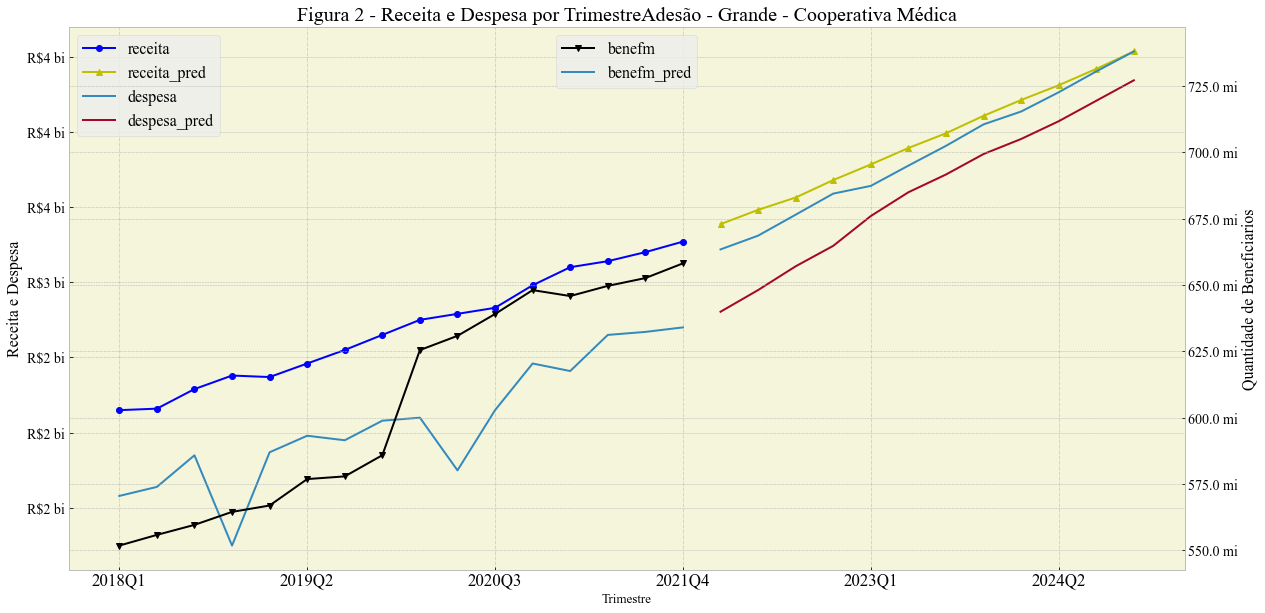

In [145]:
df_plot = ans_agrup_pred.copy()

#df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','receita_pred','despesa','despesa_pred'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre' + grupo, fontsize = 20)
#ax1.set_xticks(df_plot.index)
#ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['benefm', 'benefm_pred'], figsize=(20,10), style=['kv-'], ax=ax2)
#ax2.set_xticks(df_plot.index)
#ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(['{:.1f} mi'.format(x/1e3) for x in yticks], fontsize = 14)
ax2.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot